<span>
<b>Authors:</b> 
<a href="http://------">Ornela Danushi </a>
<a href="http://------">Gerlando Gramaglia </a>
<a href="http://------">Domenico Profumo </a><br/>
<b>Python version:</b>  3.x<br/>
</span>

# Data Preparation

In [1]:
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr
import seaborn as sn

In [2]:
df = pd.read_csv('dataset/matches_datacleaning.csv', index_col = 0)
pd.set_option('display.max_columns', None) # to visualize all the columns
df.info()


C:\Users\Gerlando\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 185750 entries, 0 to 185749
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          185750 non-null  object 
 1   tourney_name        185750 non-null  object 
 2   surface             185588 non-null  object 
 3   draw_size           185750 non-null  float64
 4   tourney_level       185750 non-null  object 
 5   tourney_date        185750 non-null  object 
 6   match_num           185750 non-null  float64
 7   winner_id           185750 non-null  float64
 8   winner_name         185750 non-null  object 
 9   winner_hand         185750 non-null  object 
 10  winner_ioc          185750 non-null  object 
 11  loser_id            185750 non-null  float64
 12  loser_name          185750 non-null  object 
 13  loser_hand          185750 non-null  object 
 14  loser_ioc           185750 non-null  object 
 15  score               185581 non-nul

In [3]:
df['tourney_date'] = pd.to_datetime(df['tourney_date'])
df['tourney_year'] = df['tourney_date'].dt.year

### Functions

In [4]:
def create_new_colums(winner_attr, loser_attr, attr):
    col1=df[['winner_name',winner_attr]].copy()
    col2=df[['loser_name',loser_attr]].copy()
    col2.rename(columns={'loser_name': 'winner_name'}, inplace = True)
    col2.rename(columns={loser_attr: winner_attr}, inplace = True)
    name2 = col1.append(col2) 
    name2.rename(columns={'winner_name': 'name',winner_attr:attr}, inplace = True)
    name2.drop_duplicates(inplace=True)
    return name2


In [5]:
def create_df(series):
    tmp = pd.DataFrame(series)
    tmp.reset_index(inplace=True)
    return tmp

def count_occ(df, attr_to_count):
    tmp = df[attr_to_count].value_counts(dropna=False)
    tmp = create_df(tmp)
    return tmp

In [6]:
def sum_col(df, gb_attr, attr_to_count, n_gb_attr, n_attr_to_count):
    player =df.groupby(gb_attr)[attr_to_count].sum()
    player = create_df(player)
    player.set_axis([n_gb_attr, n_attr_to_count], axis=1, inplace=True)
    return player


## Dataframe with Players profile

### Name, num_matches, ratio

Are identified these new attributes from the joining of both winner and loser attributes referring to each player. After count the total number of matches per player and compute the ratio between the number of won matches in relation to number of played matches.

To discover if a player's name is not an interesting value count the name's occurences both in winner_name and loser_name, if its occurrences are very low then not consider it. Assume this, also because if there are few statistics about a player then this means it is not sufficient to construct an exaustive profile.


In [7]:
#matches won per player
num_matches_won = count_occ(df, 'winner_name')
num_matches_won.set_axis(['name', 'num_matches'], axis=1, inplace=True)

#matches loss per player
num_matches_loss = count_occ(df, 'loser_name')
num_matches_loss.set_axis(['name', 'num_matches'], axis=1, inplace=True)

#total matches per player
num_matches = num_matches_won.append(num_matches_loss)
num_matches = num_matches.groupby(['name']).num_matches.sum()
num_matches = create_df(num_matches)
num_matches.set_axis(['name', 'num_matches'], axis=1, inplace=True)

#drop players with few matches
num_matches = num_matches[num_matches['num_matches'] > 10]

#add ratio
num_matches_won.set_axis(['name', 'num_matches_won'], axis=1, inplace=True) #rename attribute 'num_matches' to 'num_matches_won', otherwise we could have a conflict
num_matches = pd.merge(num_matches, num_matches_won, how = 'left', on = 'name')
num_matches['ratio'] = (num_matches['num_matches_won']/num_matches['num_matches'])*100
num_matches.fillna(0, inplace = True)

del num_matches['num_matches_won'] #reduntant column

#RENAME our database
player_profile = num_matches
player_profile

,name,num_matches,ratio
0,AARON ADDISON,11,18.181818
1,ABBIE MYERS,157,47.770701
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000
3,ABIGAIL DESIATNIKOV,12,58.333333
4,ABIGAIL TERE APISAH,126,58.730159
...,...,...,...
3902,ZOI MEERS,26,3.846154
3903,ZORA HUDSON,27,22.222222
3904,ZOZIYA KARDAVA,78,41.025641
3905,ZSOMBOR PIROS,86,54.651163


### num_matches_2016-2019,  ratio_2016-2019,  num_matches_2020-2021, ratio_2020-2021

The statistics refer to two distinct periods due to the Covid scenario. The first one is more dense than the other.
This attributes are computed as before, so sum all the played matches for each player and compute the correspondent ratio.

In [8]:
years=df['tourney_year'].dropna()
years=years.unique()
years.sort()

for year in years:
    num_matches_year = df[df['tourney_year']==year] #takes only matches of a year
    num_m_y = 'num_matches_'+str(year)
    
    #matches won per player
    num_matches_won = count_occ(num_matches_year, 'winner_name')
    num_matches_won.set_axis(['name', num_m_y], axis=1, inplace=True)
    
    #matches loss per player
    num_matches_loss = count_occ(num_matches_year, 'loser_name')
    num_matches_loss.set_axis(['name', num_m_y], axis=1, inplace=True)
    
    #total matches per player
    num_matches = num_matches_won.append(num_matches_loss)
    num_matches = num_matches.groupby(['name'])[num_m_y].sum()
    num_matches = create_df(num_matches)
    num_matches.set_axis(['name', num_m_y], axis=1, inplace=True)
    
    #add ratio
    num_matches_won.set_axis(['name', 'num_matches_won_'+str(year)], axis=1, inplace=True) #rename attribute 'num_matches' to 'num_matches_won', otherwise we could have a conflict
    num_matches = pd.merge(num_matches, num_matches_won, how = 'left', on = 'name')
    #num_matches['ratio_'+str(year)] = num_matches['num_matches_won']/num_matches[num_m_y]
    num_matches.fillna(0, inplace = True)
    #del num_matches['num_matches_won']
    
    #add to our player profile ratio and matches of current year
    player_profile = pd.merge(player_profile, num_matches, how = 'left', on = 'name')
    player_profile.fillna(0, inplace = True) #players with no matches during a year

player_profile['num_matches_2016-2019']=player_profile['num_matches_2016']+player_profile['num_matches_2017']+player_profile['num_matches_2018']+player_profile['num_matches_2019']
del player_profile['num_matches_2016']
del player_profile['num_matches_2017']
del player_profile['num_matches_2018']
del player_profile['num_matches_2019']
player_profile['ratio_2016-2019']=player_profile['num_matches_won_2016']+player_profile['num_matches_won_2017']+player_profile['num_matches_won_2018']+player_profile['num_matches_won_2019']
player_profile['ratio_2016-2019']=(player_profile['ratio_2016-2019']/player_profile['num_matches_2016-2019'])*100
del player_profile['num_matches_won_2016']
del player_profile['num_matches_won_2017']
del player_profile['num_matches_won_2018']
del player_profile['num_matches_won_2019']

player_profile['num_matches_2020-2021']=player_profile['num_matches_2020']+player_profile['num_matches_2021']
del player_profile['num_matches_2020']
del player_profile['num_matches_2021']

player_profile['ratio_2020-2021']=player_profile['num_matches_won_2020']+player_profile['num_matches_won_2021']
player_profile['ratio_2020-2021']=(player_profile['ratio_2020-2021']/player_profile['num_matches_2020-2021'])*100
del player_profile['num_matches_won_2020']
del player_profile['num_matches_won_2021']

player_profile
    

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769
...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667


### hand

Add the hand of the player

In [9]:
df_hand=create_new_colums('winner_hand','loser_hand','hand')
df_hand.drop_duplicates(inplace=True)

player_profile=pd.merge(player_profile, df_hand, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U
...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R


### gender

Add the gender of the player

In [10]:
df_gender = create_new_colums('winner_gender','loser_gender','gender')
player_profile = pd.merge(player_profile, df_gender, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F
...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M


### nationality

Add the nationality of the player

In [11]:
df_ioc = create_new_colums('winner_ioc','loser_ioc','ioc')
df_ioc.drop_duplicates(inplace=True)

player_profile = pd.merge(player_profile, df_ioc, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG
...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN


### birth

Add the birth of the player

In [12]:
#winner_birth
winner_birth=df.groupby(['winner_name']).winner_birth.min()
winner_birth = create_df(winner_birth)
winner_birth.set_axis(['name', 'birth'], axis=1, inplace=True)

#loser_birth
loser_birth = df.groupby(['loser_name']).loser_birth.min() 
loser_birth = create_df(loser_birth)
loser_birth.set_axis(['name', 'birth'], axis=1, inplace=True)

#players_birth
name_birth = winner_birth.append(loser_birth)
name_birth.dropna(inplace=True)
name_birth.drop_duplicates(inplace=True)
name_birth = name_birth.groupby(name_birth['name']).birth.min()
name_birth = create_df(name_birth)

player_profile = pd.merge(player_profile, name_birth, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0
...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0


### ht

Add the height of the player

In [13]:
df_ht=create_new_colums('winner_ht','loser_ht','ht')
df_ht.dropna(inplace=True)
df_ht.drop_duplicates(inplace=True)
df_ht = df_ht.groupby(['name']).ht.max() 

player_profile=pd.merge(player_profile, df_ht, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0,173.181818
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868
...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0,174.800000
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN,173.181818
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0,165.312500
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000


### minutes

Add the mean of played minutes for each player

In [14]:
#mean winner minutes
win_min =df.groupby('winner_name').minutes.mean()
win_min = create_df(win_min)
win_min.set_axis(['name', 'minutes'], axis=1, inplace=True)

#mean loser minutes
loser_min = df.groupby('loser_name').minutes.mean()
loser_min = create_df(loser_min)
loser_min.set_axis(['name', 'minutes'], axis=1, inplace=True)

#mean player minutes
player_min = win_min.append(loser_min)
player_min = player_min.groupby('name').minutes.mean()

#add to player profile
player_profile = pd.merge(player_profile, player_min, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143,61.621951
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000,86.875000
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868,63.205561
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0,174.800000,60.000000
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN,173.181818,60.000000
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0,165.312500,60.000000
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000,101.407801


### perc_ace

percentage of the total number of aces with respect to the total number of first serves made 

In [15]:
#table tot ace per player 
win_ace =df.groupby('winner_name').w_ace.sum()
win_ace = create_df(win_ace)
win_ace.set_axis(['name', 'ace'], axis=1, inplace=True)

loser_ace =df.groupby('loser_name').l_ace.sum()
loser_ace = create_df(loser_ace)
loser_ace.set_axis(['name', 'ace'], axis=1, inplace=True)

player_ace = win_ace.append(loser_ace)
player_ace = player_ace.groupby('name').ace.sum()

#table tot 1stIn per player
win_1stIn =df.groupby('winner_name').w_1stIn.sum()
win_1stIn= create_df(win_1stIn)
win_1stIn.set_axis(['name', 'p_1stIn'], axis=1, inplace=True)

loser_1stIn =df.groupby('loser_name').l_1stIn.sum()
loser_1stIn = create_df(loser_1stIn)
loser_1stIn.set_axis(['name', 'p_1stIn'], axis=1, inplace=True)

player_1stIn= win_1stIn.append(loser_1stIn)
player_1stIn = player_1stIn.groupby('name').p_1stIn.sum()


p = pd.merge(player_ace, player_1stIn, how = 'left', on = 'name')
p['perc_ace'] = round((p['ace'] / p['p_1stIn'])*100, 2)
del p['ace']
del p['p_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143,61.621951,1.30
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000,86.875000,20.59
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868,63.205561,3.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0,174.800000,60.000000,0.00
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN,173.181818,60.000000,0.00
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0,165.312500,60.000000,0.00
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13


### _1stwon_1stIn

percentage of the total number of first serves won with respect to the total number of first serves made

In [16]:
win_1stwon =df.groupby('winner_name').w_1stWon.sum()
win_1stwon = create_df(win_1stwon)
win_1stwon.set_axis(['name', 'p_1stwon'], axis=1, inplace=True)

loser_1stwon =df.groupby('loser_name').l_1stWon.sum()
loser_1stwon = create_df(loser_1stwon)
loser_1stwon.set_axis(['name', 'p_1stwon'], axis=1, inplace=True)

player_1stwon= win_1stwon.append(loser_1stwon)
player_1stwon = player_1stwon.groupby('name').p_1stwon.sum()

p = pd.merge(player_1stIn, player_1stwon, how = 'left', on = 'name')
p['_1stwon_1stIn'] = (p['p_1stwon'] / p['p_1stIn']) *100
del p['p_1stwon']
del p['p_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364


#### serv_won_tot_seve 

total number of won serves, calculated as the sum of 1st_won and 2nd_won with respect to the the total number of services performed

In [17]:
#total service
win_svpt =df.groupby('winner_name').w_svpt.sum()
win_svpt = create_df(win_svpt)
win_svpt.set_axis(['name', 'svpt'], axis=1, inplace=True)

loser_svpt =df.groupby('loser_name').l_svpt.sum()
loser_svpt = create_df(loser_svpt)
loser_svpt.set_axis(['name', 'svpt'], axis=1, inplace=True)

player_svpt= win_svpt.append(loser_svpt)
player_svpt = player_svpt.groupby('name').svpt.sum()

#winner second service won
win_2ndwon =df.groupby('winner_name').w_2ndWon.sum()
win_2ndwon = create_df(win_2ndwon)
win_2ndwon.set_axis(['name', 'p_2ndwon'], axis=1, inplace=True)

#loser second service won
loser_2ndwon =df.groupby('loser_name').l_2ndWon.sum()
loser_2ndwon = create_df(loser_2ndwon)
loser_2ndwon.set_axis(['name', 'p_2ndwon'], axis=1, inplace=True)

#player second service won
player_2ndwon= win_2ndwon.append(loser_2ndwon)
player_2ndwon = player_2ndwon.groupby('name').p_2ndwon.sum()

#total number of service won (1st won + 2nd won)
total_serv_won = pd.merge(player_1stwon, player_2ndwon, how = 'left', on = 'name')
total_serv_won['total_won'] = total_serv_won['p_1stwon'] + total_serv_won['p_2ndwon']
total_serv_won.drop(['p_1stwon', 'p_2ndwon'], axis=1, inplace=True)

#calculate ratio: total_serv_won / total_serve
tot = pd.merge(total_serv_won, player_svpt, how = 'left', on = 'name')
tot['serv_won_tot_seve'] = (tot['total_won'] / tot['svpt'])*100
tot.drop(['total_won', 'svpt'], axis=1, inplace=True)

player_profile = pd.merge(player_profile, tot, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,58.785530
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,27.000327
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,61.370124
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,56.538319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,58.493586


### bpFaced, bpSaved

total number of breakpoints for each player

In [18]:
#breakpoints faced
win_bpfaced = sum_col(df, 'winner_name', 'w_bpFaced', 'name', 'bpFaced')
loser_bpfaced = sum_col(df, 'loser_name', 'l_bpFaced', 'name', 'bpFaced')
player_bpfaced = win_bpfaced.append(loser_bpfaced)
player_bpfaced = player_bpfaced.groupby('name').bpFaced.sum()

player_profile = pd.merge(player_profile, player_bpfaced, how = 'left', on = 'name')

#breakpoints saved
win_bpsaved = sum_col(df, 'winner_name', 'w_bpSaved', 'name', 'bpsaved')
loser_bpsaved = sum_col(df, 'loser_name', 'l_bpSaved', 'name', 'bpsaved')
player_bpsaved = win_bpsaved.append(loser_bpsaved)
player_bpsaved = player_bpsaved.groupby('name').bpsaved.sum()

player_profile = pd.merge(player_profile, player_bpsaved, how = 'left', on = 'name')

player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,58.785530,83.0,52.0
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,27.000327,819.0,255.0
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,61.370124,111.0,67.0
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,56.538319,1081.0,618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,58.493586,678.0,385.0


### perc_df and perc_df_2ndIn

percentage of double faults respect first serve and second serve. The number of second services is calculated by the difference between number of total services and first service

In [19]:
#double faults
win_df = sum_col(df, 'winner_name', 'w_df', 'name', 'df')
loser_df= sum_col(df, 'loser_name', 'l_df', 'name', 'df')
player_df = win_df.append(loser_df)
player_df = player_df.groupby('name').df.sum()

#% double faults
p = pd.merge(player_df, player_1stIn, how = 'left', on = 'name')
p['perc_df'] = round((p['df'] / p['p_1stIn'])*100, 2)
del p['df']
del p['p_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,58.785530,83.0,52.0,12.32
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,27.000327,819.0,255.0,4.67
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,61.370124,111.0,67.0,10.89
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,56.538319,1081.0,618.0,11.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,58.493586,678.0,385.0,5.84


In [20]:
#percetage of double faults respect to 2ndserve
player_2ndIn = pd.merge(player_svpt, player_1stIn, how = 'left', on = 'name')
player_2ndIn['p_2ndIn'] = player_2ndIn['svpt'] - player_2ndIn['p_1stIn']
player_2ndIn.reset_index(inplace = True)
del player_2ndIn['svpt'] 
del player_2ndIn['p_1stIn']

p = pd.merge(player_df, player_2ndIn, how = 'left', on = 'name')
p['perc_df_2ndIn'] = round((p['df'] / p['p_2ndIn'])*100, 2)
del p['df']
del p['p_2ndIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,58.785530,83.0,52.0,12.32,14.17
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,27.000327,819.0,255.0,4.67,8.17
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,61.370124,111.0,67.0,10.89,10.07
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,56.538319,1081.0,618.0,11.42,19.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,58.493586,678.0,385.0,5.84,8.56


### perc_2ndwon

percentage of second won with respect to second serves made

In [21]:
player_perc2w = pd.merge(player_2ndwon, player_2ndIn, how = 'left', on = 'name')
player_perc2w['perc_2ndwon'] = round((player_perc2w['p_2ndwon'] / player_perc2w['p_2ndIn'])*100, 2)
del player_perc2w['p_2ndwon']
del player_perc2w['p_2ndIn']

player_profile = pd.merge(player_profile, player_perc2w, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,58.785530,83.0,52.0,12.32,14.17,47.78
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,27.000327,819.0,255.0,4.67,8.17,22.10
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,61.370124,111.0,67.0,10.89,10.07,51.65
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,56.538319,1081.0,618.0,11.42,19.52,54.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,58.493586,678.0,385.0,5.84,8.56,49.38


### perc_v_ace_

percentage of aces suffered, calculated as the total number of opponents’ aces with respect to the total number of opponents’ first serves made against the player

In [22]:
#ace against
win_v_ace = sum_col(df, 'winner_name', 'l_ace', 'name', 'v_ace')
loser_v_ace = sum_col(df, 'loser_name', 'w_ace', 'name', 'v_ace')

player_v_ace = win_v_ace.append(loser_v_ace)
player_v_ace = player_v_ace.groupby('name').v_ace.sum()

In [23]:
#1stIn against
win_v_1stIn = sum_col(df, 'winner_name', 'l_1stIn', 'name', 'v_1stIn')
loser_v_1stIn = sum_col(df, 'loser_name', 'w_1stIn', 'name', 'v_1stIn')

player_v_1stIn= win_v_1stIn.append(loser_v_1stIn)
player_v_1stIn = player_v_1stIn.groupby('name').v_1stIn.sum()

In [24]:
player_perc_v_ace = pd.merge(player_v_ace, player_v_1stIn, how = 'left', on = 'name')
player_perc_v_ace['perc_v_ace'] = round((player_perc_v_ace['v_ace'] / player_perc_v_ace['v_1stIn'])*100, 2)
del player_perc_v_ace['v_ace']
del player_perc_v_ace['v_1stIn']

player_profile = pd.merge(player_profile, player_perc_v_ace, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,58.785530,83.0,52.0,12.32,14.17,47.78,8.82
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,27.000327,819.0,255.0,4.67,8.17,22.10,3.18
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,61.370124,111.0,67.0,10.89,10.07,51.65,7.12
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.47
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,56.538319,1081.0,618.0,11.42,19.52,54.16,3.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.17
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.09
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.50
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,58.493586,678.0,385.0,5.84,8.56,49.38,8.47


### perc_v_df

percentage of double faults suffered, as above, calculated as the total number of opponents’ double faults with respect to the total number of opponents’ first serves made, against the player

In [25]:
win_v_df = sum_col(df, 'winner_name', 'l_df', 'name', 'v_df')
loser_v_df= sum_col(df, 'loser_name', 'w_df', 'name', 'v_df')
player_v_df = win_v_df.append(loser_v_df)
player_v_df = player_v_df.groupby('name').v_df.sum()
#% double faults
p = pd.merge(player_v_df, player_v_1stIn, how = 'left', on = 'name')
p['perc_v_df'] = round((p['v_df'] / p['v_1stIn'])*100, 2)
del p['v_df']
del p['v_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,58.785530,83.0,52.0,12.32,14.17,47.78,8.82,5.88
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,27.000327,819.0,255.0,4.67,8.17,22.10,3.18,5.39
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,61.370124,111.0,67.0,10.89,10.07,51.65,7.12,10.10
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.47,3.74
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,56.538319,1081.0,618.0,11.42,19.52,54.16,3.76,7.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.17,0.75
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.09,0.19
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.50,1.65
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,58.493586,678.0,385.0,5.84,8.56,49.38,8.47,7.21


### perc_v_1stwon

percentage of first serve return points won, calculated as the total number of opponents’ first serves won with respect to the total number of opponents’ first serves made against the player.

In [26]:
win_v_1stwon = sum_col(df, 'winner_name', 'l_1stWon', 'name', 'v_1stwon')
loser_v_1stwon = sum_col(df, 'loser_name', 'w_1stWon', 'name', 'v_1stwon')
player_v_1stwon = win_v_1stwon.append(loser_v_1stwon)
player_v_1stwon = player_v_1stwon.groupby('name').v_1stwon.sum()

#% double faults
p = pd.merge(player_v_1stwon, player_v_1stIn, how = 'left', on = 'name')
p['perc_v_1stwon'] = round((p['v_1stwon'] / p['v_1stIn'])*100, 2)
del p['v_1stwon']
del p['v_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
0,AARON ADDISON,11,18.181818,10.0,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,58.785530,83.0,52.0,12.32,14.17,47.78,8.82,5.88,75.79
1,ABBIE MYERS,157,47.770701,142.0,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,27.000327,819.0,255.0,4.67,8.17,22.10,3.18,5.39,37.90
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,13.0,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,61.370124,111.0,67.0,10.89,10.07,51.65,7.12,10.10,70.86
3,ABIGAIL DESIATNIKOV,12,58.333333,12.0,58.333333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.47,3.74,24.18
4,ABIGAIL TERE APISAH,126,58.730159,113.0,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,56.538319,1081.0,618.0,11.42,19.52,54.16,3.76,7.94,47.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,3.846154,22.0,0.000000,4.0,25.000000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.17,0.75,2.82
3903,ZORA HUDSON,27,22.222222,13.0,30.769231,14.0,14.285714,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.09,0.19,3.19
3904,ZOZIYA KARDAVA,78,41.025641,40.0,47.500000,38.0,34.210526,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.50,1.65,10.79
3905,ZSOMBOR PIROS,86,54.651163,83.0,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,58.493586,678.0,385.0,5.84,8.56,49.38,8.47,7.21,66.69


## Rapresent all dataset

In [27]:
player_profile.info()
p=player_profile

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3907 entries, 0 to 3906
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   3907 non-null   object 
 1   num_matches            3907 non-null   int64  
 2   ratio                  3907 non-null   float64
 3   num_matches_2016-2019  3907 non-null   float64
 4   ratio_2016-2019        3785 non-null   float64
 5   num_matches_2020-2021  3907 non-null   float64
 6   ratio_2020-2021        2629 non-null   float64
 7   hand                   3907 non-null   object 
 8   gender                 3907 non-null   object 
 9   ioc                    3907 non-null   object 
 10  birth                  3686 non-null   float64
 11  ht                     3907 non-null   float64
 12  minutes                3907 non-null   float64
 13  perc_ace               3907 non-null   float64
 14  _1stwon_1stIn          3907 non-null   float64
 15  serv

### Players : Numerical Attribute

In [28]:
pl_num=p.copy()
pl_num=pl_num.drop(['name','hand','gender','ioc'],1)

<ipython-input-28-e354fe4f876f>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  pl_num=pl_num.drop(['name','hand','gender','ioc'],1)


### Players : Categorical Attribute

In [29]:
pl_cat=pd.DataFrame()
pl_cat['name']=p.name
pl_cat['hand']=p.hand
pl_cat['gender']=p.gender
pl_cat['ioc']=p.ioc

## Data Statistics of the Players Dataset

### numerical attributes

In [30]:
pl_num.describe()

,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
count,3907.000000,3907.000000,3907.000000,3785.000000,3907.000000,2629.000000,3686.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000
mean,90.136422,44.197165,71.353468,43.147385,18.782954,42.016847,1995.504612,175.908828,71.370910,3.655416,31.192151,28.157958,485.642949,266.795239,4.122572,6.683768,23.360988,4.051735,4.331682,34.798600
std,88.293180,14.500695,73.128136,16.128252,23.890902,20.576355,5.105639,7.565531,15.961101,5.236571,31.186732,27.925500,712.094629,398.355457,4.632813,7.398661,23.203451,4.573322,2.836328,26.068013
min,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1964.000000,155.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,35.483871,15.000000,33.333333,0.000000,31.818182,1992.000000,172.137868,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.720000,1.810000,11.645000
50%,52.000000,46.540881,39.000000,46.153846,8.000000,46.666667,1996.000000,173.714286,60.270270,0.050000,22.472022,20.984429,104.000000,53.000000,3.490000,6.290000,18.680000,1.800000,4.070000,26.000000
75%,140.000000,54.706176,112.000000,54.601227,31.000000,56.250000,2000.000000,180.166667,85.382454,6.300000,64.642470,58.126424,747.500000,404.500000,7.315000,11.740000,47.635000,6.950000,6.790000,66.095000
max,387.000000,85.250737,316.000000,100.000000,147.000000,100.000000,2006.000000,211.000000,132.724084,40.000000,82.386560,77.725056,3868.000000,2370.000000,29.930000,54.850000,94.180000,23.170000,17.890000,81.880000


It is noted that for most of them the value 0 is the predominant one and that value represents both null values and good values. Since it is not easy to distinguish the 2 situations it has been reasoned as follows: in the case in which a player has the majority of 0s then it has to be removed because it has not enough statistical information, otherwise it has to be kept

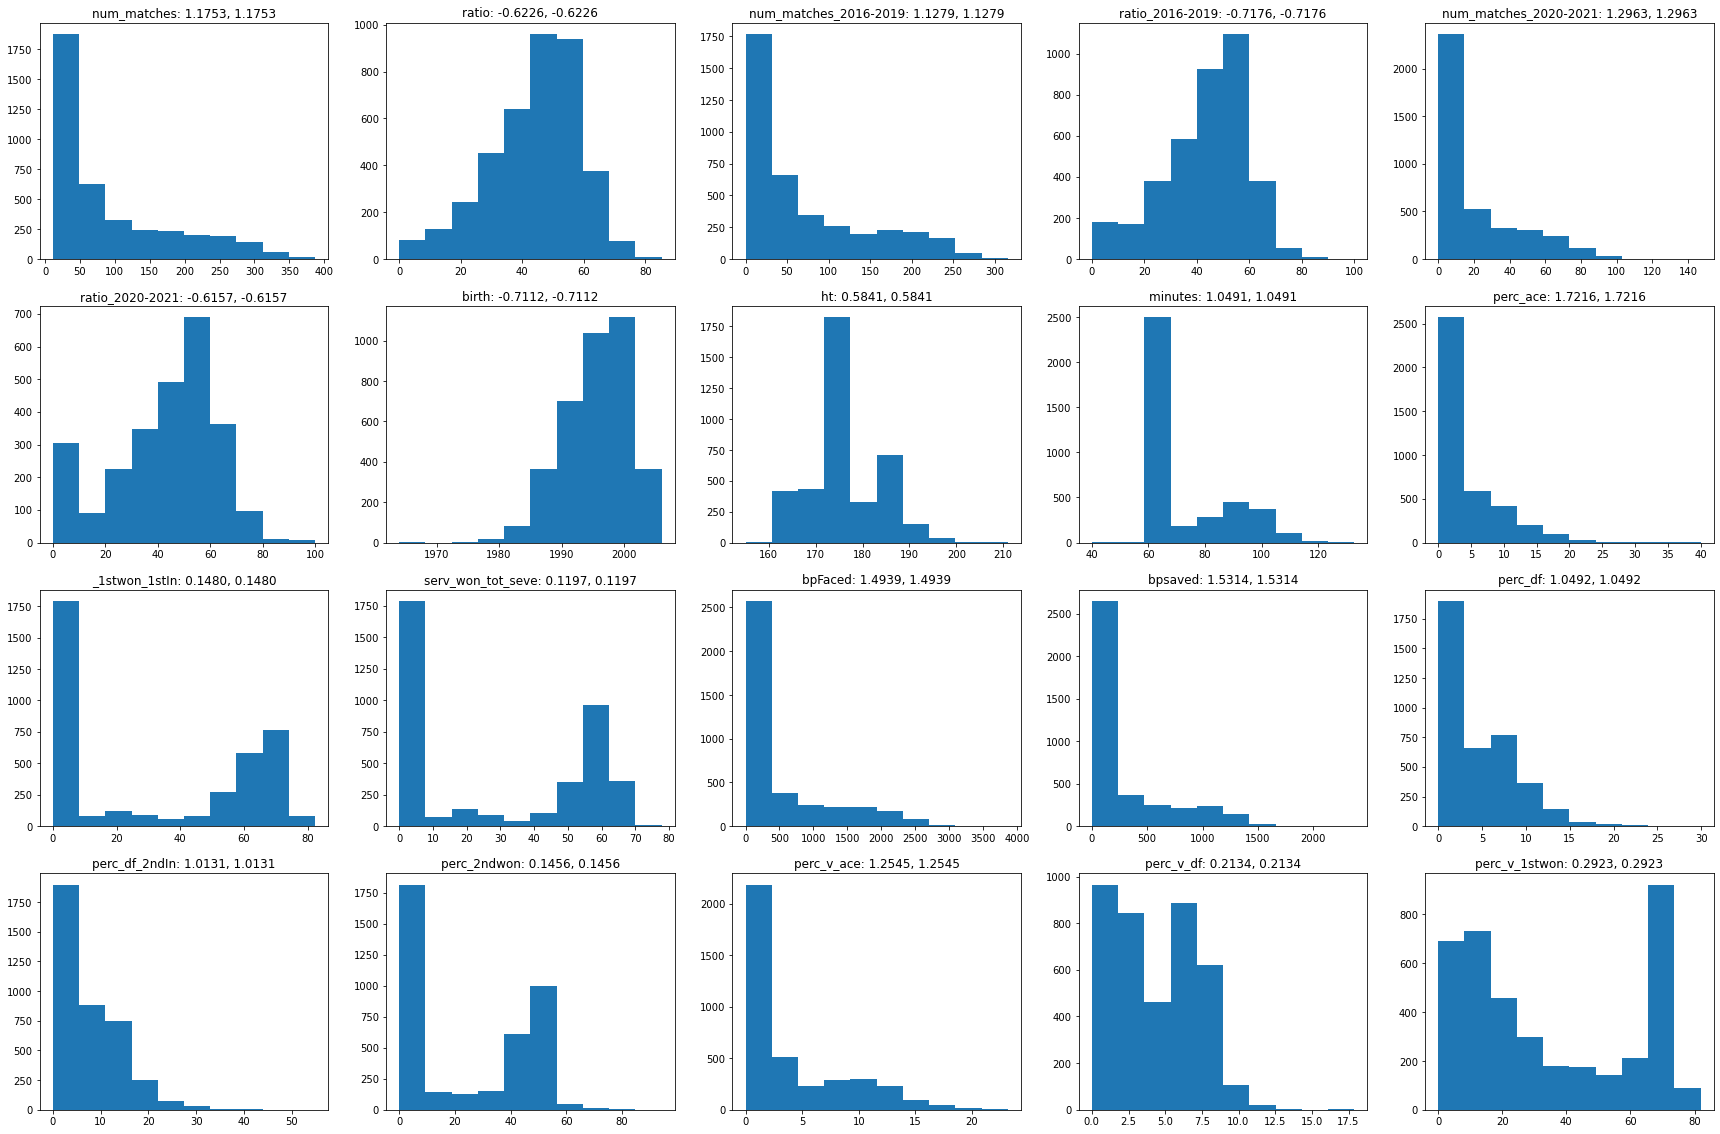

In [31]:
f, axs = plt.subplots(nrows = 4, ncols = 5, figsize=(30,20))

for i in range(len(pl_num.columns)):
    axs[int(i/5)][i%5].hist(pl_num[pl_num.columns[i]])
    axs[int(i/5)][i%5].set_title(pl_num.columns[i] + ": " + '{:.4f}'.format(pl_num[pl_num.columns[i]].skew()) + ", " + '{:.4f}'.format(pl_num[pl_num.columns[i]].skew()))
plt.show()

### categorical attribute

In [32]:
print(pl_cat.gender.unique())

['M' 'F']


In [33]:
print(pl_cat.gender.value_counts())

F    2822
M    1085
Name: gender, dtype: int64


In [34]:
print(pl_cat[pl_cat.gender.isna()])

Empty DataFrame
Columns: [name, hand, gender, ioc]
Index: []


In [35]:
print(pl_cat.hand.value_counts())

R    1876
U    1782
L     249
Name: hand, dtype: int64


Looking the distribution of the hands is observed that the amount of U is quite the same of R while in the previous dataset there was a predominant presence of R.

Looking the distribution of the gender is observed that the behavior is the same as the previous dataset.

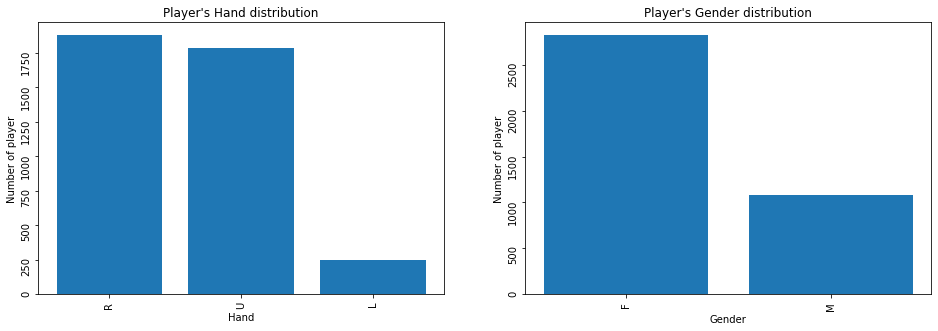

In [36]:
f, axs = plt.subplots(ncols=2, figsize=(16,5))
axs[0].bar(['R','U','L'],pl_cat.hand.value_counts())
axs[0].tick_params(labelrotation=90)
axs[0].set_title("Player's Hand distribution")
axs[0].set_xlabel("Hand")
axs[0].set_ylabel("Number of player")

axs[1].bar(sorted(pl_cat.gender.unique()),pl_cat.gender.value_counts())
axs[1].tick_params(labelrotation=90)
axs[1].set_title("Player's Gender distribution")
axs[1].set_xlabel("Gender")
axs[1].set_ylabel("Number of player")

plt.show() 

The distribution of ioc is preserved

<AxesSubplot:title={'center':'Distribution of ioc'}, xlabel='ioc'>

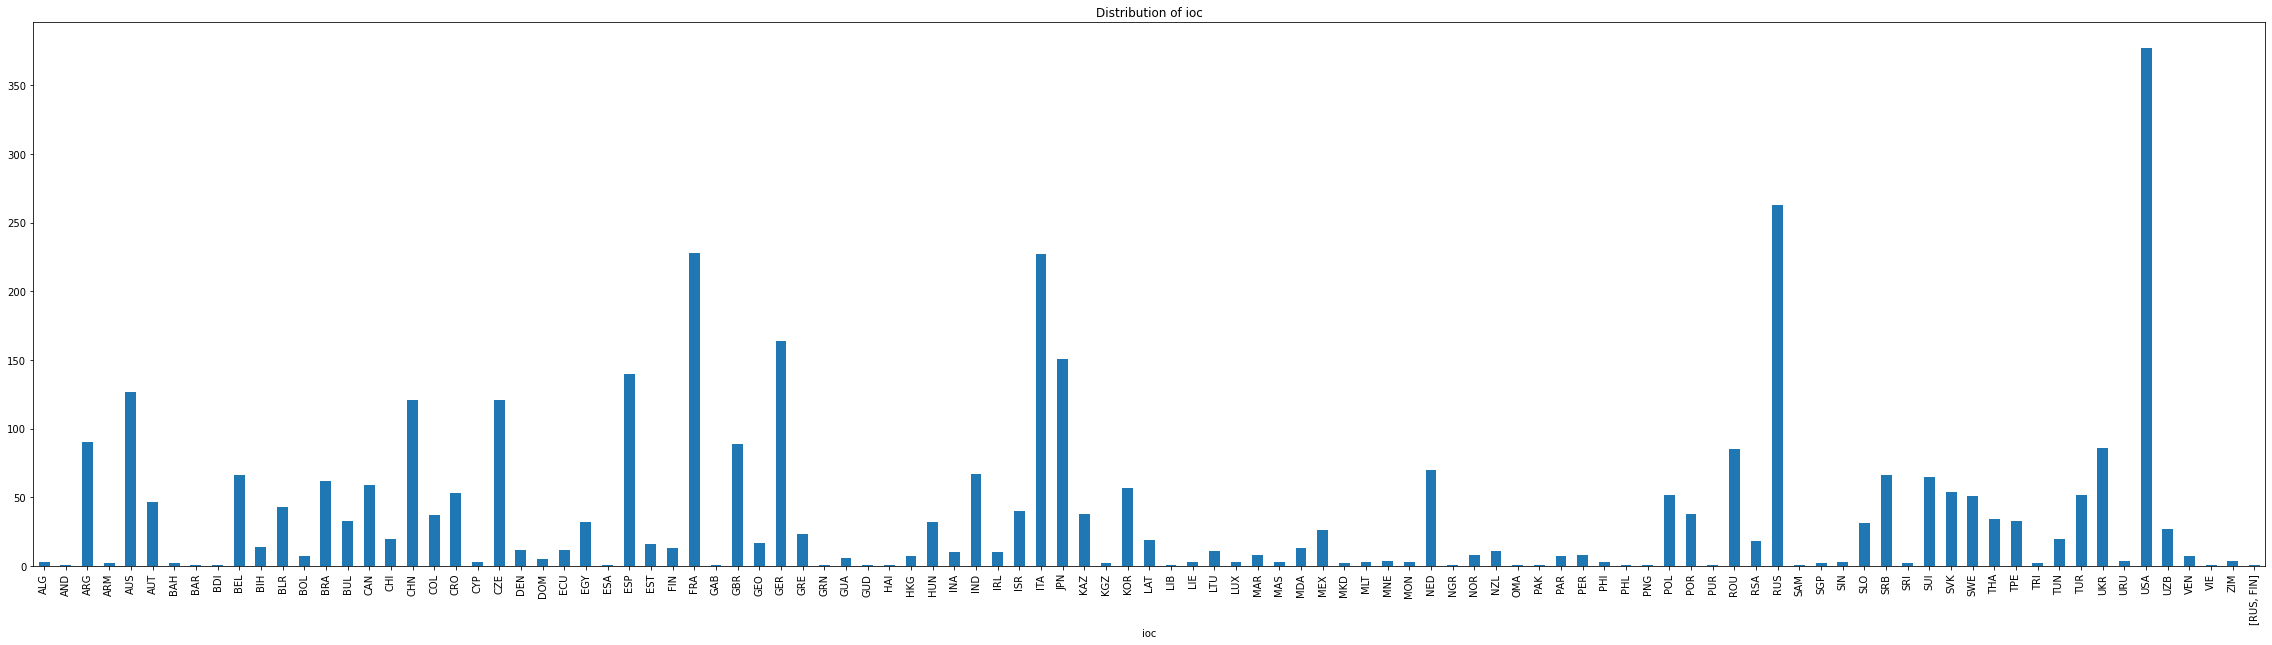

In [37]:
lf = pl_cat.groupby([pl_cat.ioc]).size()
lf.plot(
    figsize=(40, 10), 
    title="Distribution of ioc", 
    kind='bar')

Nationality rapresented by at least 10 players

<AxesSubplot:title={'center':'Distribution of ioc'}, xlabel='ioc'>

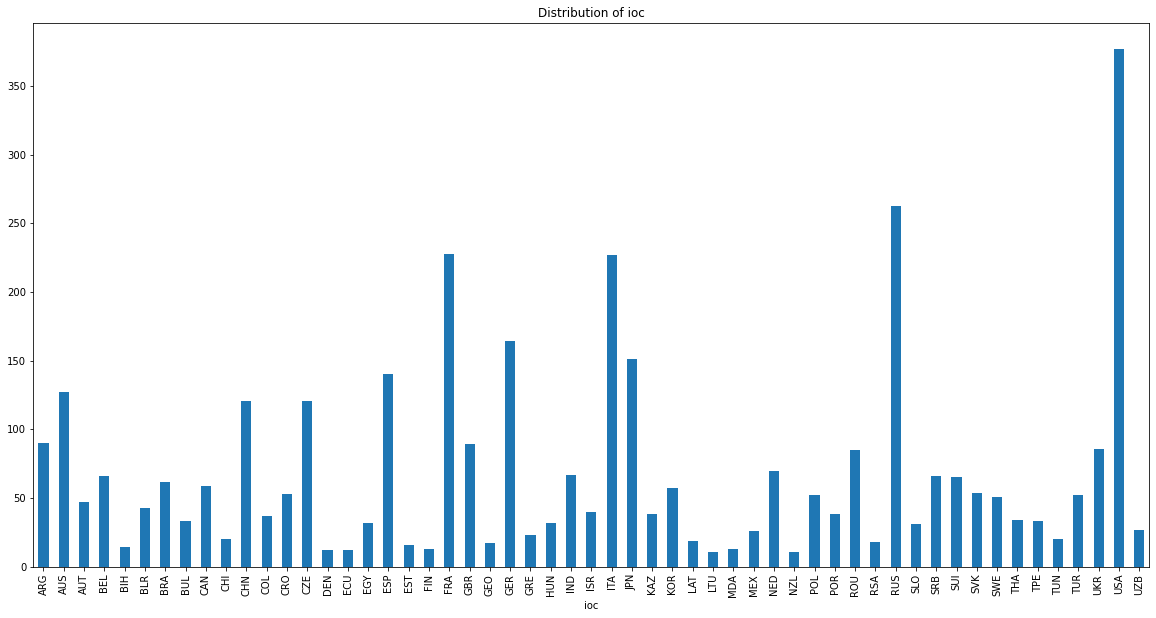

In [38]:
lf = pl_cat.groupby(pl_cat.ioc).size()
lf=lf[lf>10]
lf.plot(
    figsize=(20, 10), 
    title="Distribution of ioc", 
    kind='bar')

## Missing Values

Drop all players who skill attributes are all zeros. The distribution of histograms changes accordingly with more sparse data.

In [39]:
b_na=pl_num[(pl_num.perc_ace==0) & (pl_num._1stwon_1stIn==0) & (pl_num.serv_won_tot_seve==0)& (pl_num.bpFaced==0)& (pl_num.bpsaved==0)
           & (pl_num.perc_df==0) & (pl_num.perc_df_2ndIn==0) & (pl_num.perc_2ndwon==0)]

In [40]:
player_profile.drop(b_na.index, inplace = True)
pl_num.drop(b_na.index, inplace = True)

It is important to note that the zero value is no more the most prevalent one, this also suggests that the zeros were predominant in the same rows

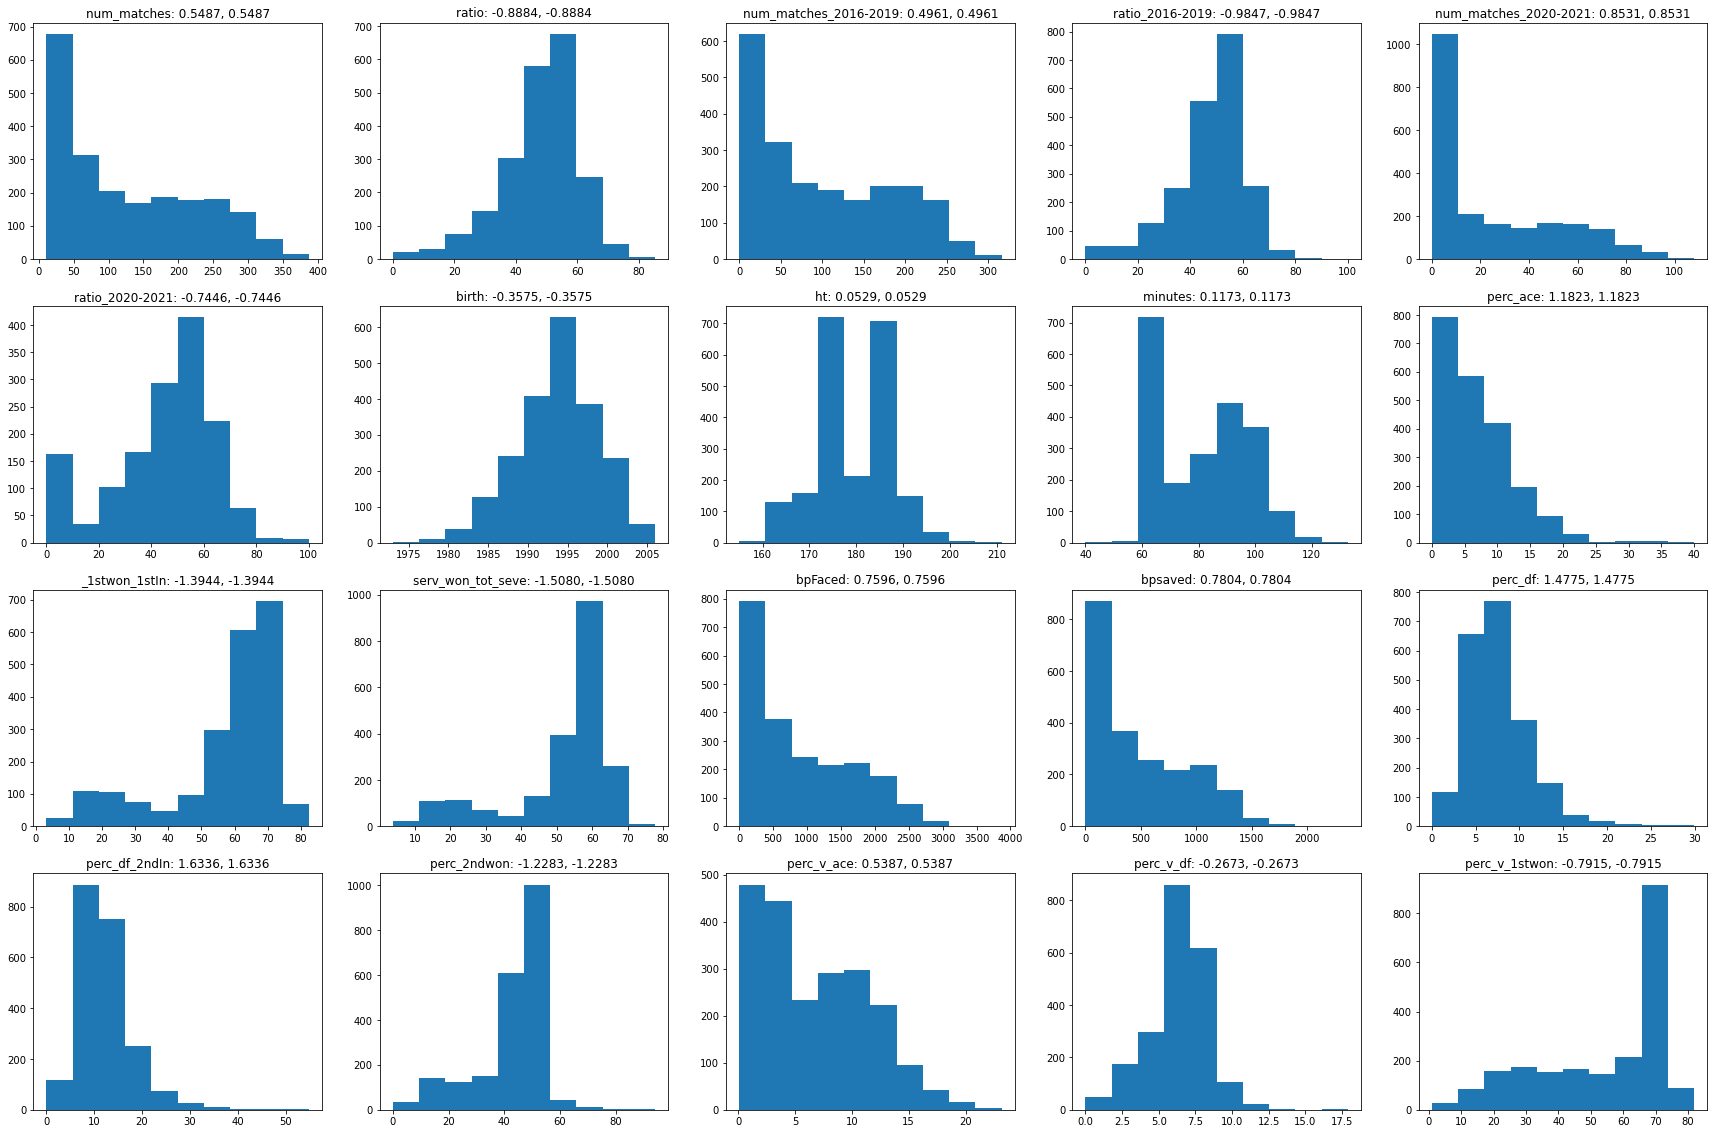

In [41]:
f, axs = plt.subplots(nrows = 4, ncols = 5, figsize=(30,20))

for i in range(len(pl_num.columns)):
    axs[int(i/5)][i%5].hist(pl_num[pl_num.columns[i]])
    axs[int(i/5)][i%5].set_title(pl_num.columns[i] + ": " + '{:.4f}'.format(pl_num[pl_num.columns[i]].skew()) + ", " + '{:.4f}'.format(pl_num[pl_num.columns[i]].skew()))
plt.show()

In [42]:
player_profile.isna().sum()

name                       0
num_matches                0
ratio                      0
num_matches_2016-2019      0
ratio_2016-2019           19
num_matches_2020-2021      0
ratio_2020-2021          648
hand                       0
gender                     0
ioc                        0
birth                      4
ht                         0
minutes                    0
perc_ace                   0
_1stwon_1stIn              0
serv_won_tot_seve          0
bpFaced                    0
bpsaved                    0
perc_df                    0
perc_df_2ndIn              0
perc_2ndwon                0
perc_v_ace                 0
perc_v_df                  0
perc_v_1stwon              0
dtype: int64

#### Resolve the NaN birth attributes searching on ATP Website

In [43]:
player_profile[player_profile['birth'].isna()]

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
248,AMARNI BANKS,26,46.153846,3.0,33.333333,23.0,47.826087,R,F,GBR,NaN,177.714286,61.571429,0.00,45.333333,38.678679,84.0,14.0,6.67,11.38,27.32,1.33,1.90,16.25
992,DIMITRA PAVLOU,18,11.111111,7.0,0.000000,11.0,18.181818,R,F,GRE,NaN,177.000000,59.718750,0.00,31.773050,25.329815,176.0,80.0,18.16,29.63,14.81,1.00,3.84,19.49
2935,PAULINA BAKAITE,15,13.333333,15.0,13.333333,0.0,NaN,U,F,LTU,NaN,172.137868,97.307692,3.15,41.079460,39.199255,159.0,88.0,9.15,14.99,36.12,2.83,5.98,54.02
3151,RUI XUAN WANG,12,8.333333,12.0,8.333333,0.0,NaN,U,M,CHN,NaN,183.666667,92.772727,8.52,53.884712,50.972222,103.0,52.0,13.53,16.82,47.35,9.16,5.93,73.58


In [44]:
player_profile.loc[player_profile['name']=='AMARNI BANKS', 'birth']=2002
player_profile.loc[player_profile['name']=='PAULINA BAKAITE', 'birth'] =1999
player_profile.loc[player_profile['name']=='DIMITRA PAVLOU', 'birth'] =2004
player_profile.loc[player_profile['name']=='RUI XUAN WANG', 'birth'] =1996

#### Resolve the NaN ratio_2016-2019 attributes with 0, pay attention to standard deviation

In [45]:
player_profile[player_profile['ratio_2016-2019'].isna()]

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
137,ALEXANDER SHEVCHENKO,11,72.727273,0.0,NaN,11.0,72.727273,U,M,RUS,2001.0,187.266667,98.312500,9.51,71.979434,62.010444,61.0,35.0,7.71,7.96,51.72,3.96,7.27,58.59
150,ALEXANDRA EALA,33,54.545455,0.0,NaN,33.0,54.545455,U,F,PHL,2005.0,172.137868,64.005556,2.52,46.722561,44.764649,279.0,113.0,20.35,34.68,41.43,2.11,5.75,35.13
517,ARTHUR CAZAUX,27,40.740741,0.0,NaN,27.0,40.740741,R,M,FRA,2002.0,186.961538,99.332386,15.86,70.900901,61.897514,170.0,102.0,3.42,4.41,50.29,7.05,4.95,69.04
573,BARBORA PALICOVA,30,56.666667,0.0,NaN,30.0,56.666667,R,F,CZE,2004.0,175.785714,63.000000,2.06,25.732383,29.974937,143.0,52.0,6.18,10.66,37.30,1.65,2.62,15.51
648,BRIANA SZABO,27,59.259259,0.0,NaN,27.0,59.259259,U,F,ROU,2006.0,173.714286,60.954545,0.00,16.161616,14.943887,99.0,44.0,1.01,1.82,12.75,0.17,1.02,5.16
688,CARLOS GIMENO VALERO,34,61.764706,0.0,NaN,34.0,61.764706,U,M,ESP,2001.0,182.652174,98.225275,2.57,64.350064,58.232236,249.0,142.0,12.74,26.26,45.62,7.12,7.75,62.44
1003,DOMINIC STEPHAN STRICKER,18,61.111111,0.0,NaN,18.0,61.111111,U,M,SUI,2003.0,182.833333,99.870130,22.71,78.502415,66.928571,99.0,63.0,5.19,7.52,50.17,14.30,4.80,73.47
1024,DUJE AJDUKOVIC,54,59.259259,0.0,NaN,54.0,59.259259,R,M,CRO,2001.0,194.000000,105.488636,7.91,66.984258,59.492754,444.0,273.0,5.80,8.11,49.02,5.36,5.81,64.23
2058,KYRIAN JACQUET,26,53.846154,0.0,NaN,26.0,53.846154,R,M,FRA,2001.0,186.961538,93.065476,7.58,66.190901,59.638554,188.0,97.0,7.23,11.49,49.22,7.04,6.45,66.08
2200,LUCA NARDI,20,25.000000,0.0,NaN,20.0,25.000000,R,M,ITA,2003.0,185.705882,83.100000,6.24,68.253968,61.215933,124.0,71.0,6.01,9.65,49.91,10.48,5.70,72.29


In [46]:
player_profile['ratio_2016-2019'].describe()

count    2108.000000
mean       47.577738
std        13.517354
min         0.000000
25%        41.231618
50%        50.000000
75%        56.382979
max       100.000000
Name: ratio_2016-2019, dtype: float64

In [47]:
player_profile['ratio_2016-2019'].fillna(0.0, inplace=True)

In [48]:
player_profile['ratio_2016-2019'].describe()

count    2127.000000
mean       47.152737
std        14.182218
min         0.000000
25%        40.909091
50%        50.000000
75%        56.334953
max       100.000000
Name: ratio_2016-2019, dtype: float64

In [49]:
player_profile['ratio_2020-2021'].describe()

count    1479.000000
mean       43.889479
std        20.549081
min         0.000000
25%        33.333333
50%        48.648649
75%        57.924641
max       100.000000
Name: ratio_2020-2021, dtype: float64

In [50]:
player_profile['ratio_2020-2021'].fillna(0.0, inplace=True)

In [51]:
player_profile['ratio_2020-2021'].describe()

count    2127.000000
mean       30.518354
std        26.491811
min         0.000000
25%         0.000000
50%        36.734694
75%        53.061224
max       100.000000
Name: ratio_2020-2021, dtype: float64

## Outliers

In [52]:
pl_num.isna().sum()

num_matches                0
ratio                      0
num_matches_2016-2019      0
ratio_2016-2019           19
num_matches_2020-2021      0
ratio_2020-2021          648
birth                      4
ht                         0
minutes                    0
perc_ace                   0
_1stwon_1stIn              0
serv_won_tot_seve          0
bpFaced                    0
bpsaved                    0
perc_df                    0
perc_df_2ndIn              0
perc_2ndwon                0
perc_v_ace                 0
perc_v_df                  0
perc_v_1stwon              0
dtype: int64

### BoxPlot of all attributes

Are presented some boxplot graphs of the most similar attributes, in which the more distant points are not treated as outliers but as particular values that will help in determining the best or worst performances of the players.

<AxesSubplot:>

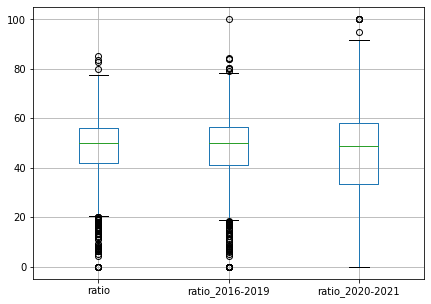

In [53]:
df_box = pl_num[['ratio', 'ratio_2016-2019', 'ratio_2020-2021']].copy()
df_box.boxplot(figsize=(7,5))

<AxesSubplot:>

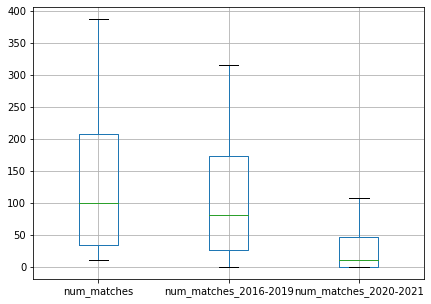

In [54]:
df_box = pl_num[['num_matches', 'num_matches_2016-2019', 'num_matches_2020-2021']].copy()
df_box.boxplot(figsize=(7,5))

<AxesSubplot:>

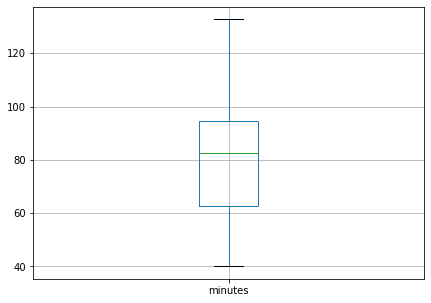

In [55]:
df_box = pl_num[['minutes']].copy()
df_box.boxplot(figsize=(7,5))

<AxesSubplot:>

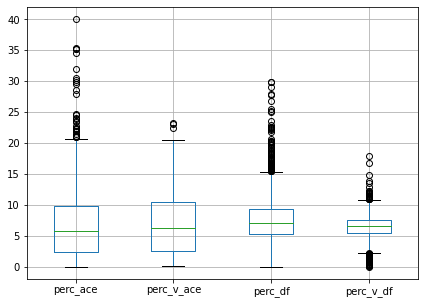

In [56]:
df_box = pl_num[['perc_ace','perc_v_ace','perc_df','perc_v_df']].copy()
df_box.boxplot(figsize=(7,5))

<AxesSubplot:>

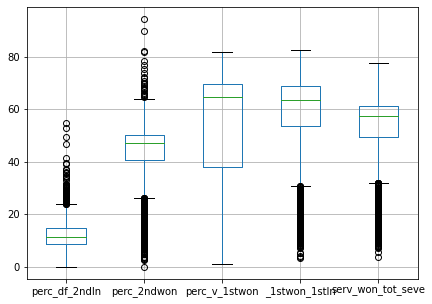

In [57]:
df_box = pl_num[['perc_df_2ndIn','perc_2ndwon','perc_v_1stwon','_1stwon_1stIn','serv_won_tot_seve']].copy()
df_box.boxplot(figsize=(7,5))

<AxesSubplot:>

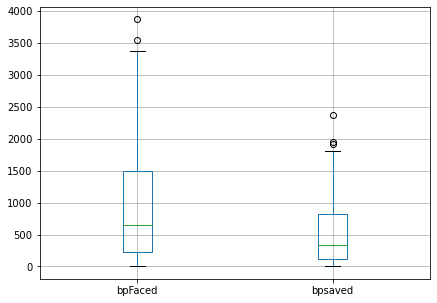

In [58]:
df_box = pl_num[['bpFaced','bpsaved']].copy()
df_box.boxplot(figsize=(7,5))

In [59]:
def detecting_outliers(attr):
    q1 = attr.quantile(0.25)
    q3 = attr.quantile(0.75)
    iqr = q3 - q1
    L = q1 - 2*iqr
    R = q3 + 2*iqr
    return L, R

In [60]:
def detecting_outliers_numerical(df, attr, substitute):
    print("BEFORE")
    #df.hist(attr) 
    plt.show()
    df.boxplot(attr) 
    plt.show()
    
    L, R = detecting_outliers(df[attr])
    print("L, R", L, R)
    if L < 0:
        L = 0

    df_outliers = df[(df[attr]< L) | (df[attr] > R)]
    new_df = df.drop(df_outliers.index)

    if substitute == 'median':
        median = df[attr].median()
        print("facciamo la mediana", median)
        df_outliers.loc[(df_outliers[attr] < L), attr] = median 
        df_outliers.loc[(df_outliers[attr] > R), attr] = median
    else:
        df_outliers.loc[(df_outliers[attr] < L), attr] = L
        df_outliers.loc[(df_outliers[attr] > R), attr] = R
    
    print("AFTER")
    new_df.append(df_outliers)
    #new_df[attr].plot.hist()
    plt.show()
    new_df[attr].plot.box()
    plt.show()
    
    return new_df 

In [61]:
L, R = detecting_outliers(pl_num.ratio)
outliers = player_profile[(player_profile.ratio > R) | (player_profile.ratio < L)]
outliers

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
61,ALASTAIR GRAY,11,9.090909,7.0,0.000000,4.0,25.000000,R,M,GBR,1998.0,183.428571,98.450000,8.97,67.937220,56.901042,89.0,49.0,11.21,15.53,41.61,6.34,6.34,70.50
79,ALEJANDRO MENDOZA,19,5.263158,16.0,6.250000,3.0,0.000000,R,M,BOL,1990.0,185.674783,87.305556,9.21,60.690789,49.224490,187.0,99.0,25.00,24.64,37.93,14.14,12.15,78.04
385,ANDREY YAKOVLEV,20,0.000000,20.0,0.000000,0.0,0.000000,R,M,RUS,1992.0,187.266667,48.450000,1.72,46.336207,37.613636,157.0,48.0,27.80,31.01,27.88,19.12,8.57,80.48
485,ANTON CHEKHOV,13,0.000000,13.0,0.000000,0.0,0.000000,R,M,RUS,1993.0,187.266667,75.923077,7.49,53.395785,47.675963,124.0,62.0,15.22,19.94,40.18,7.06,7.52,70.16
608,BERNARDO SARAIVA,13,7.692308,13.0,7.692308,0.0,0.000000,R,M,POR,1993.0,179.800000,79.458333,2.75,59.957627,53.275649,99.0,45.0,9.75,13.65,43.92,11.04,6.02,71.49
812,CONGSUP CONGCAR,11,0.000000,10.0,0.000000,1.0,0.000000,U,M,THA,1996.0,177.000000,78.000000,4.12,56.701031,51.862464,103.0,55.0,8.51,10.65,45.81,13.59,6.25,75.82
915,DARIJA JURAK,12,0.000000,11.0,0.000000,1.0,0.000000,R,F,CRO,1984.0,180.000000,60.166667,1.99,50.331126,46.366279,110.0,51.0,7.73,14.89,38.72,9.09,9.09,75.57
992,DIMITRA PAVLOU,18,11.111111,7.0,0.000000,11.0,18.181818,R,F,GRE,2004.0,177.000000,59.718750,0.00,31.773050,25.329815,176.0,80.0,18.16,29.63,14.81,1.00,3.84,19.49
1018,DOSTANBEK TASHBULATOV,16,6.250000,9.0,11.111111,7.0,0.000000,U,M,KAZ,2000.0,188.400000,63.200000,2.97,52.602230,48.331539,142.0,65.0,9.11,12.53,42.46,7.34,7.53,71.24
1166,ENRICO BECUZZI,13,7.692308,13.0,7.692308,0.0,0.000000,R,M,ITA,1973.0,185.705882,40.000000,1.36,47.619048,39.028777,110.0,44.0,25.17,28.24,29.39,17.39,7.97,81.88


drop all players with ratio attributes equals to zero because they are few matches or are surely outlier

In [62]:
outliers=pl_num[pl_num['ratio'] == 0.0 ]

player_profile.drop(outliers.index, inplace = True)

In [63]:
pl_num=player_profile
pl_num=pl_num.drop(['name','hand','gender','ioc'],1)
pl_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120 entries, 0 to 3906
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_matches            2120 non-null   int64  
 1   ratio                  2120 non-null   float64
 2   num_matches_2016-2019  2120 non-null   float64
 3   ratio_2016-2019        2120 non-null   float64
 4   num_matches_2020-2021  2120 non-null   float64
 5   ratio_2020-2021        2120 non-null   float64
 6   birth                  2120 non-null   float64
 7   ht                     2120 non-null   float64
 8   minutes                2120 non-null   float64
 9   perc_ace               2120 non-null   float64
 10  _1stwon_1stIn          2120 non-null   float64
 11  serv_won_tot_seve      2120 non-null   float64
 12  bpFaced                2120 non-null   float64
 13  bpsaved                2120 non-null   float64
 14  perc_df                2120 non-null   float64
 15  perc

<ipython-input-63-92600ec43522>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  pl_num=pl_num.drop(['name','hand','gender','ioc'],1)


### Final Box Plot

<AxesSubplot:>

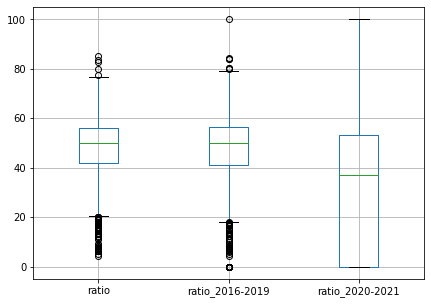

In [64]:
df_box = pl_num[['ratio', 'ratio_2016-2019', 'ratio_2020-2021']].copy()
df_box.boxplot(figsize=(7,5))

<AxesSubplot:>

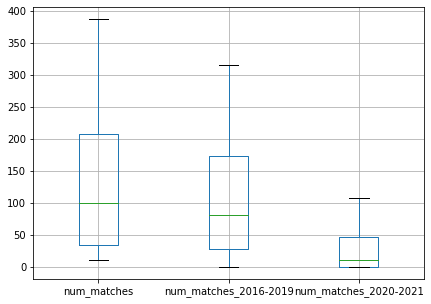

In [65]:
df_box = pl_num[['num_matches', 'num_matches_2016-2019', 'num_matches_2020-2021']].copy()
df_box.boxplot(figsize=(7,5))

<AxesSubplot:>

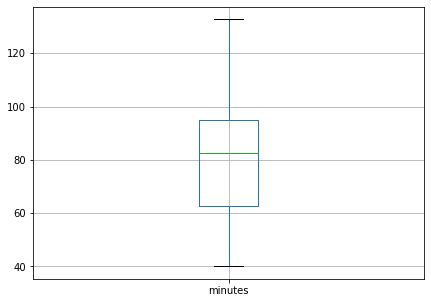

In [66]:
df_box = pl_num[['minutes']].copy()
df_box.boxplot(figsize=(7,5))

<AxesSubplot:>

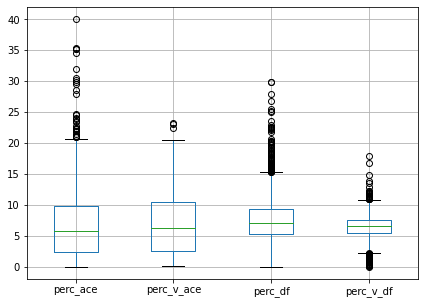

In [67]:
df_box = pl_num[['perc_ace','perc_v_ace','perc_df','perc_v_df']].copy()
df_box.boxplot(figsize=(7,5))

<AxesSubplot:>

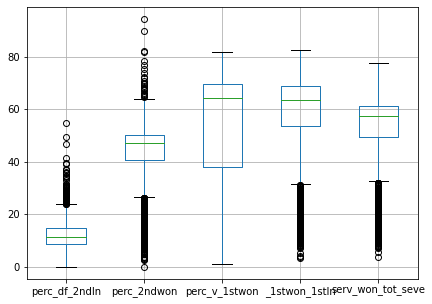

In [68]:
df_box = pl_num[['perc_df_2ndIn','perc_2ndwon','perc_v_1stwon','_1stwon_1stIn','serv_won_tot_seve']].copy()
df_box.boxplot(figsize=(7,5))

<AxesSubplot:>

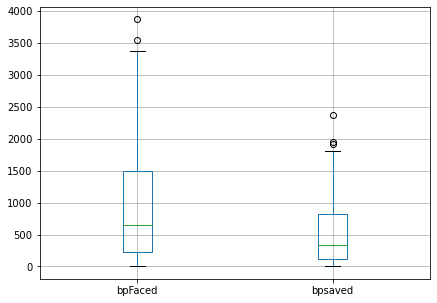

In [69]:
df_box = pl_num[['bpFaced','bpsaved']].copy()
df_box.boxplot(figsize=(7,5))

### CORRELATION

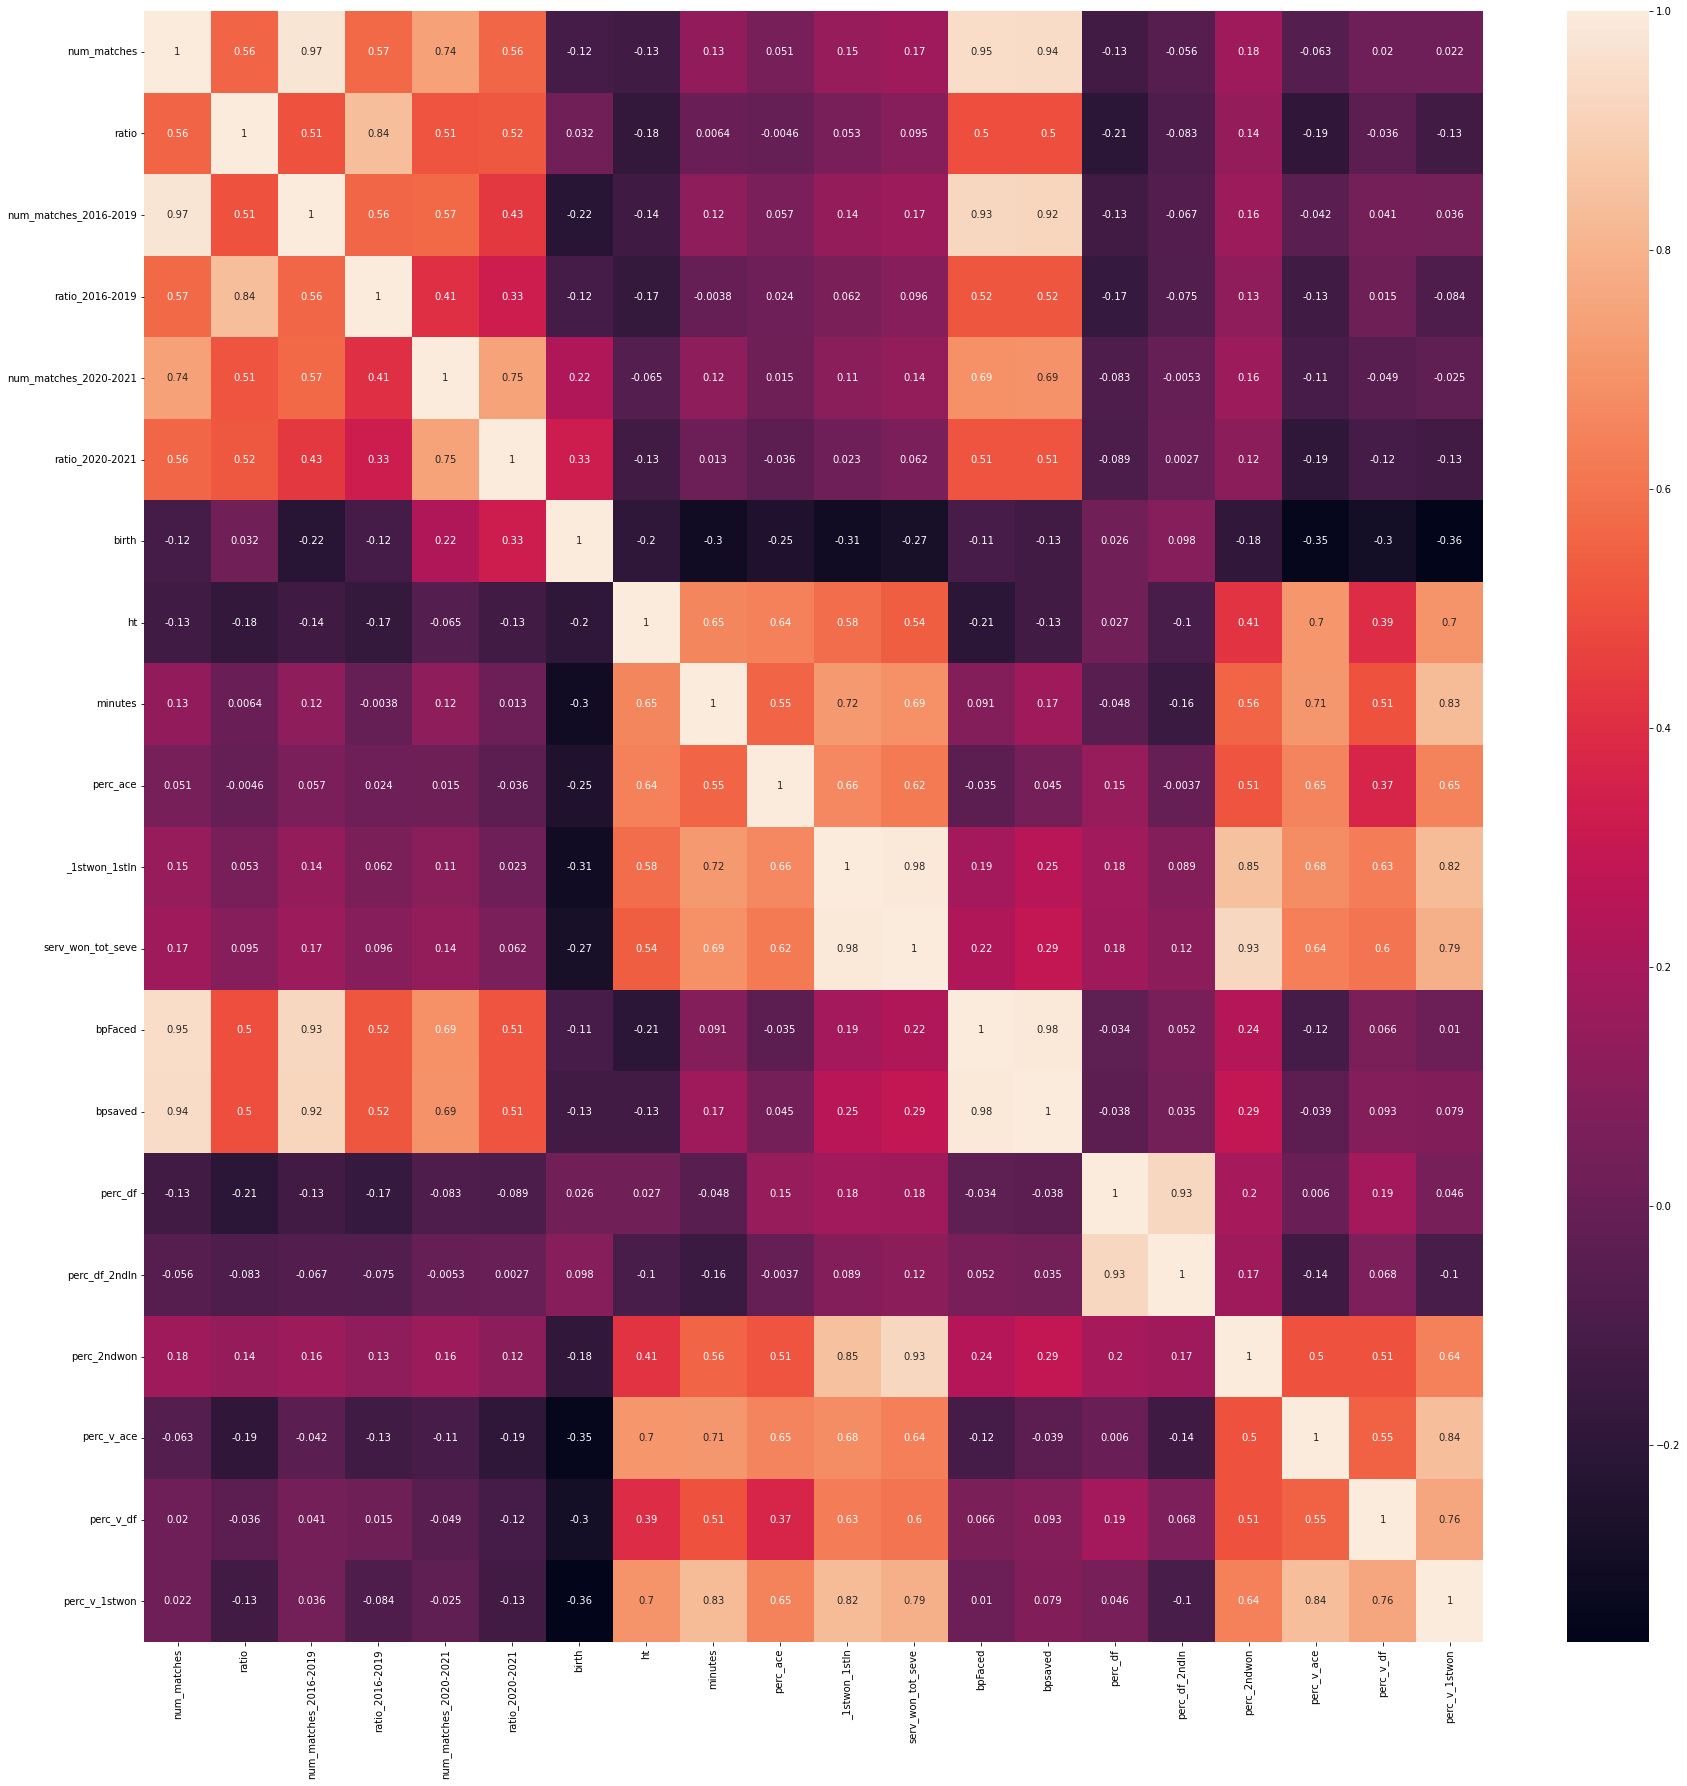

In [70]:
p = player_profile
#p = p.replace({0:np.nan})
matrix = p.corr()
fig, ax = plt.subplots(figsize=(30, 30)) #Sample figsize in inches
sn.heatmap(matrix, annot=True)
plt.show()

In [71]:
def scatter_subplots(cell, x, y, x_label, y_label):
    cell.scatter(x, y)
    cell.set_title('Corr(' + x_label + ',' + y_label +'): ' + str(x.corr(y)))
    cell.set_xlabel(x_label)
    cell.set_ylabel(y_label)


In [72]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(pl_num.columns)):
    for j in range(i+1, len(pl_num.columns)):
        corr = pl_num[pl_num.columns[i]].corr(pl_num[pl_num.columns[j]])
        if  corr > corr_threshold:
            print(pl_num.columns[i] + "\t" + pl_num.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
num_matches	num_matches_2016-2019	0.9744
num_matches	bpFaced	0.9469
num_matches	bpsaved	0.9422
num_matches_2016-2019	bpFaced	0.9271
num_matches_2016-2019	bpsaved	0.9201
_1stwon_1stIn	serv_won_tot_seve	0.9843
serv_won_tot_seve	perc_2ndwon	0.9257
bpFaced	bpsaved	0.9843
perc_df	perc_df_2ndIn	0.9276


### scatter with correlation >0.90

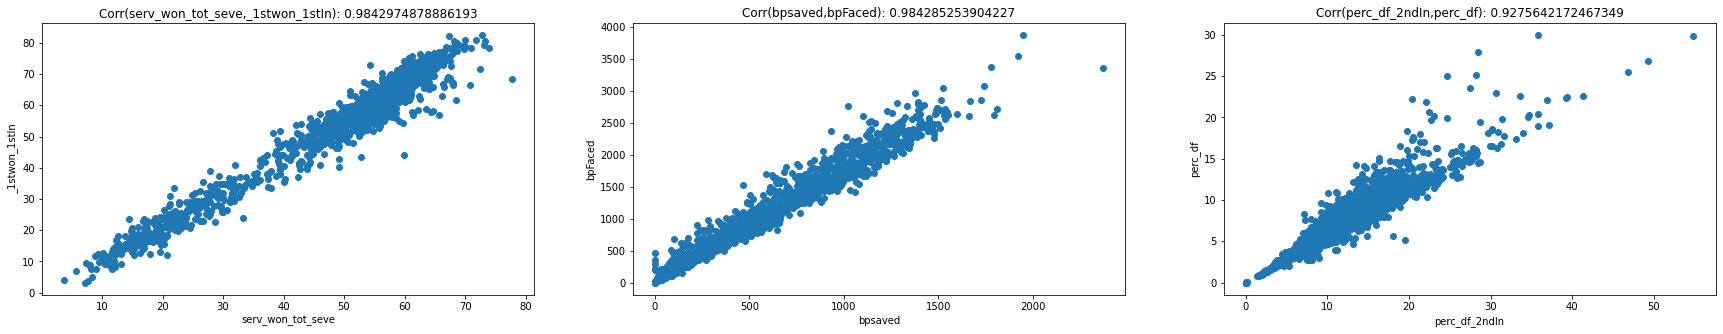

In [73]:
f, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(30,5))
scatter_subplots(axs[0], p.serv_won_tot_seve, p._1stwon_1stIn, 'serv_won_tot_seve', '_1stwon_1stIn')
scatter_subplots(axs[1], p.bpsaved, p.bpFaced, 'bpsaved', 'bpFaced')
scatter_subplots(axs[2], p.perc_df_2ndIn, p.perc_df, 'perc_df_2ndIn', 'perc_df')
plt.show()

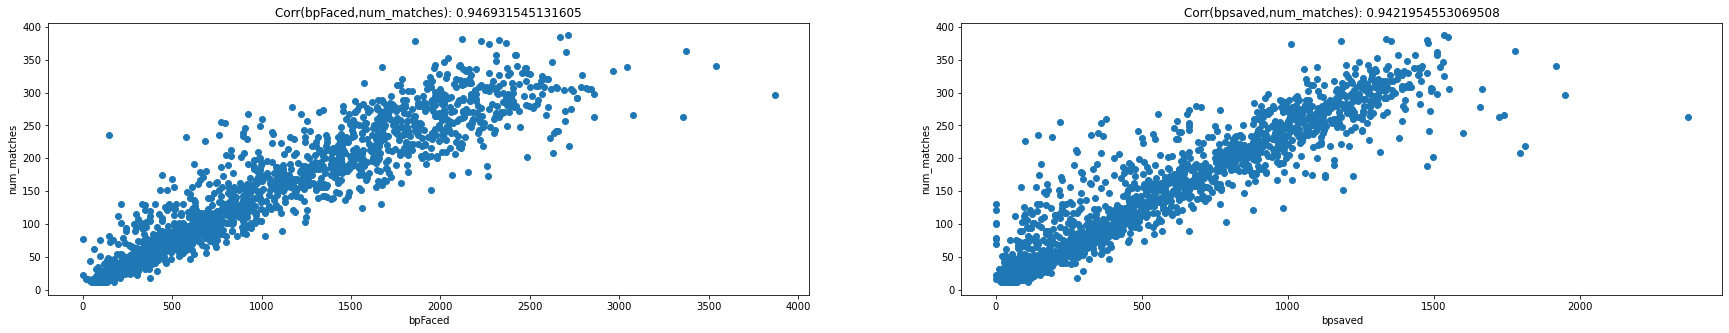

In [74]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(30,5))
scatter_subplots(axs[0], p['bpFaced'], p.num_matches, 'bpFaced', 'num_matches')
scatter_subplots(axs[1], p['bpsaved'], p.num_matches, 'bpsaved', 'num_matches')

## drop colums and save new csv

In [75]:
p.drop(columns=['num_matches_2016-2019','perc_df_2ndIn','bpFaced', 'bpsaved', 'serv_won_tot_seve'], inplace=True)


In [76]:
p

,name,num_matches,ratio,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
0,AARON ADDISON,11,18.181818,20.000000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,12.32,47.78,8.82,5.88,75.79
1,ABBIE MYERS,157,47.770701,47.887324,15.0,46.666667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,4.67,22.10,3.18,5.39,37.90
2,ABHINAV SANJEEV SHANMUGAM,16,50.000000,46.153846,3.0,66.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,10.89,51.65,7.12,10.10,70.86
4,ABIGAIL TERE APISAH,126,58.730159,57.522124,13.0,69.230769,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,11.42,54.16,3.76,7.94,47.32
5,ABIR EL FAHIMI,14,21.428571,21.428571,0.0,0.000000,U,F,MAR,1995.0,172.137868,49.409091,0.00,20.185185,16.30,17.20,0.51,2.55,11.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3892,ZIZOU BERGS,78,62.820513,50.000000,42.0,73.809524,R,M,BEL,1999.0,173.666667,96.377199,9.43,69.639842,4.39,51.35,5.99,7.03,68.12
3897,ZOE HIVES,118,57.627119,57.627119,0.0,0.000000,U,F,AUS,1996.0,170.857143,66.047353,4.00,56.382179,7.00,60.39,3.67,8.14,51.36
3899,ZOE KRUGER,76,44.736842,38.596491,19.0,63.157895,U,F,RSA,2002.0,172.137868,61.131653,2.33,49.786675,7.81,44.11,1.91,3.95,27.01
3905,ZSOMBOR PIROS,86,54.651163,54.216867,3.0,66.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,5.84,49.38,8.47,7.21,66.69


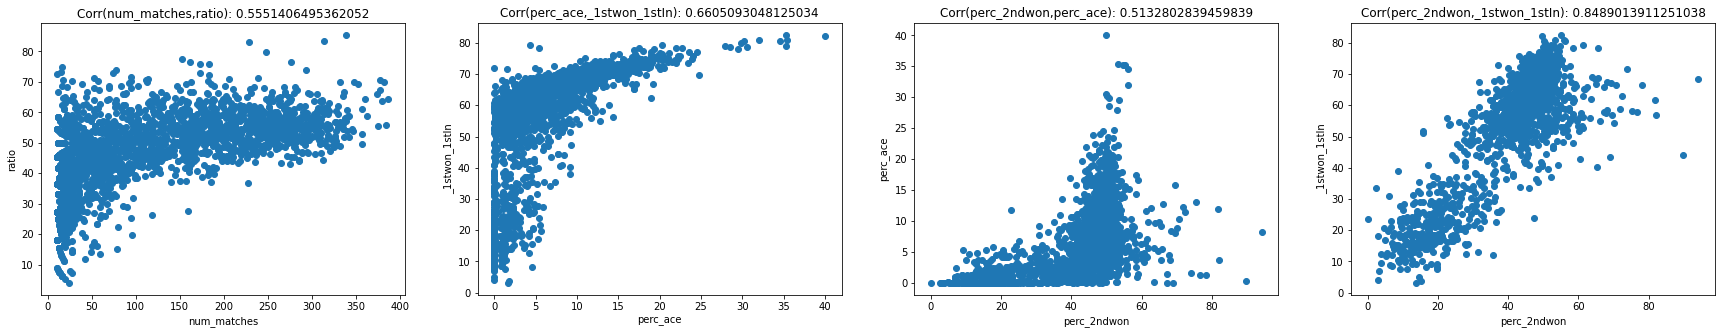

In [85]:
f, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(30,5))

scatter_subplots(axs[0], p['num_matches'], p.ratio, 'num_matches', 'ratio')
scatter_subplots(axs[1], p['perc_ace'], p._1stwon_1stIn, 'perc_ace', '_1stwon_1stIn')
scatter_subplots(axs[2], p['perc_2ndwon'], p.perc_ace, 'perc_2ndwon', 'perc_ace')
scatter_subplots(axs[3], p['perc_2ndwon'], p._1stwon_1stIn, 'perc_2ndwon', '_1stwon_1stIn')

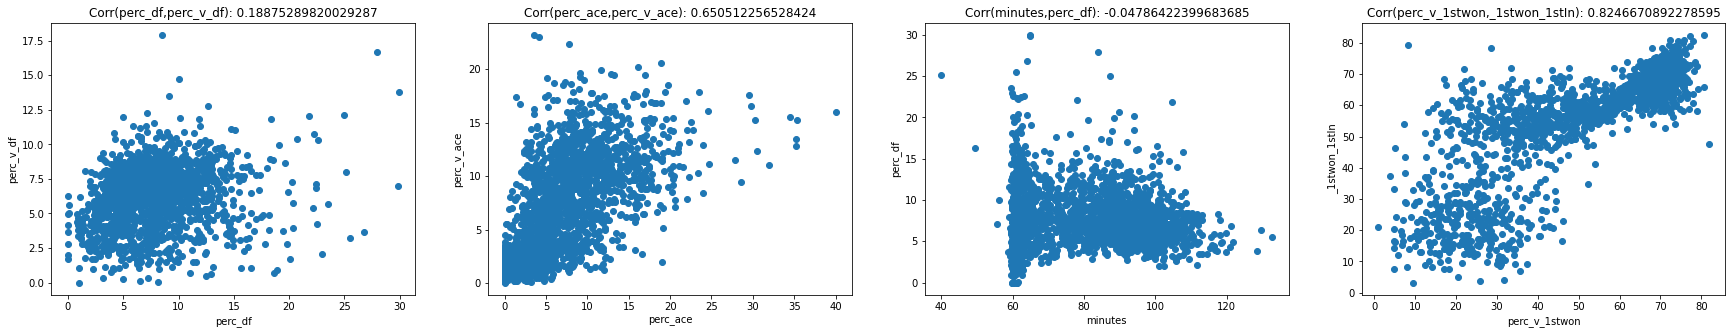

In [88]:
f, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(30,5))

scatter_subplots(axs[0], p['perc_df'], p.perc_v_df, 'perc_df', 'perc_v_df')
scatter_subplots(axs[1], p['perc_ace'], p.perc_v_ace, 'perc_ace', 'perc_v_ace')
scatter_subplots(axs[2], p['minutes'], p.perc_df, 'minutes', 'perc_df')
scatter_subplots(axs[3], p['perc_v_1stwon'], p._1stwon_1stIn, 'perc_v_1stwon', '_1stwon_1stIn')

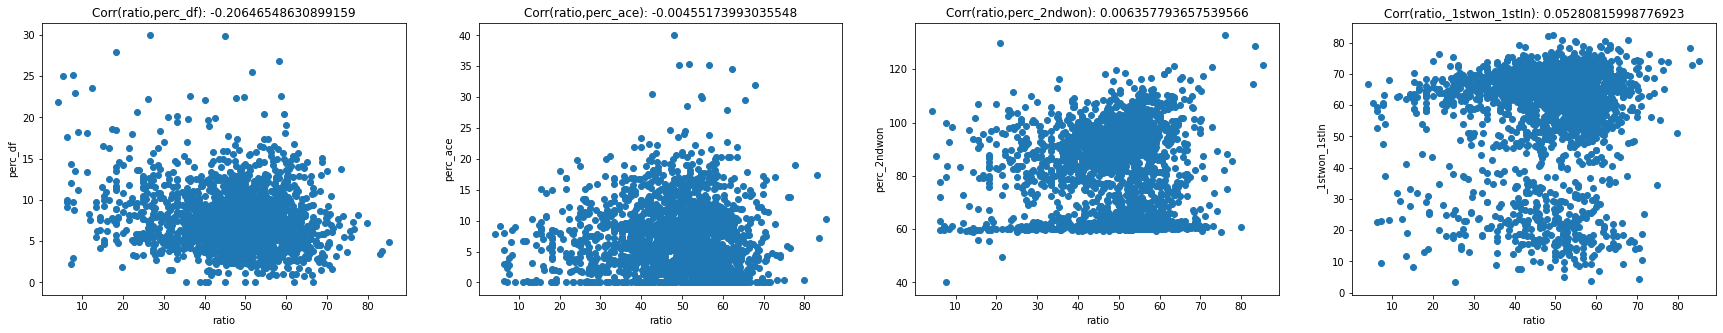

In [91]:
f, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(30,5))

scatter_subplots(axs[0], p['ratio'], p.perc_df, 'ratio', 'perc_df')
scatter_subplots(axs[1], p['ratio'], p.perc_ace, 'ratio', 'perc_ace')
scatter_subplots(axs[2], p['ratio'], p.minutes, 'ratio', 'perc_2ndwon')
scatter_subplots(axs[3], p['ratio'], p._1stwon_1stIn, 'ratio', '_1stwon_1stIn')

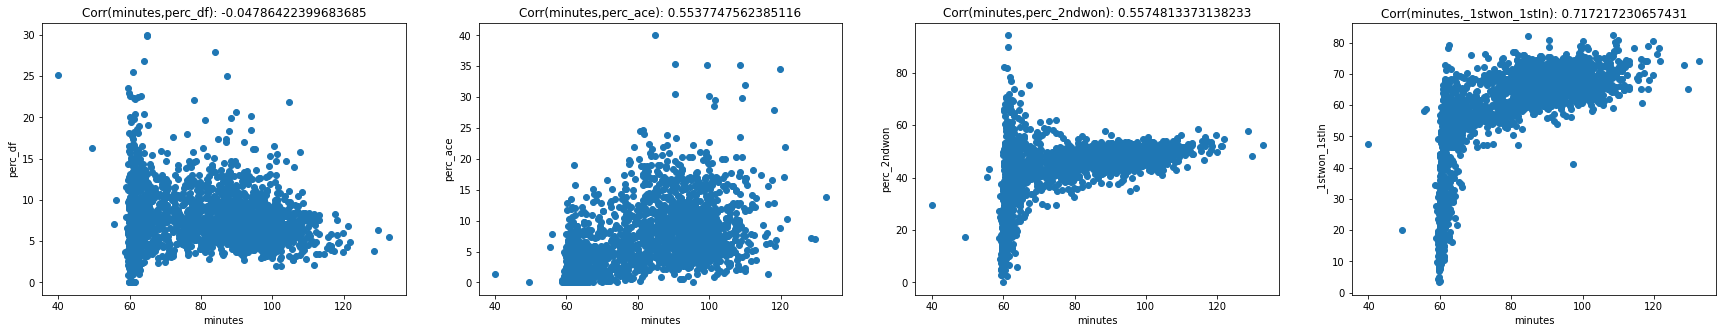

In [93]:
f, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(30,5))

scatter_subplots(axs[0], p['minutes'], p.perc_df, 'minutes', 'perc_df')
scatter_subplots(axs[1], p['minutes'], p.perc_ace, 'minutes', 'perc_ace')
scatter_subplots(axs[2], p['minutes'], p.perc_2ndwon, 'minutes', 'perc_2ndwon')
scatter_subplots(axs[3], p['minutes'], p._1stwon_1stIn, 'minutes', '_1stwon_1stIn')

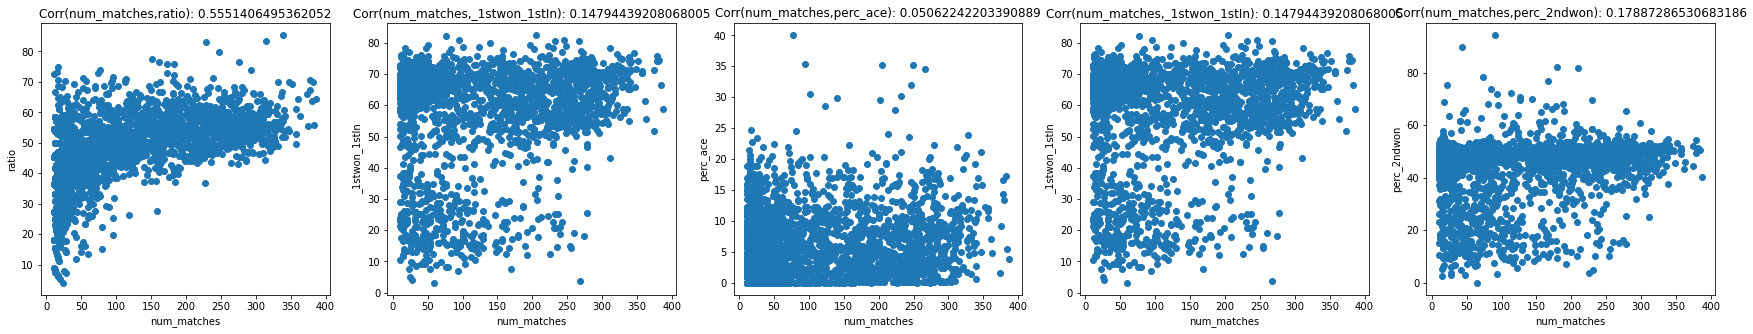

In [95]:
f, axs = plt.subplots(nrows = 1, ncols = 5, figsize=(30,5))

scatter_subplots(axs[0], p['num_matches'], p.ratio, 'num_matches', 'ratio')
scatter_subplots(axs[1], p['num_matches'], p._1stwon_1stIn, 'num_matches', '_1stwon_1stIn')
scatter_subplots(axs[2], p['num_matches'], p.perc_ace, 'num_matches', 'perc_ace')
scatter_subplots(axs[3], p['num_matches'], p._1stwon_1stIn, 'num_matches', '_1stwon_1stIn')
scatter_subplots(axs[4], p['num_matches'], p.perc_2ndwon, 'num_matches', 'perc_2ndwon')

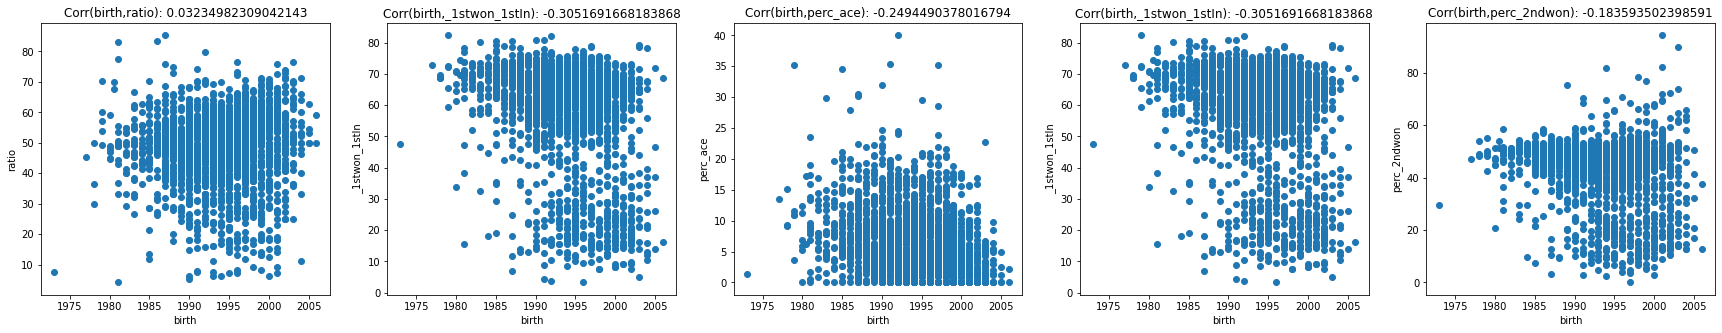

In [96]:
f, axs = plt.subplots(nrows = 1, ncols = 5, figsize=(30,5))

scatter_subplots(axs[0], p['birth'], p.ratio, 'birth', 'ratio')
scatter_subplots(axs[1], p['birth'], p._1stwon_1stIn, 'birth', '_1stwon_1stIn')
scatter_subplots(axs[2], p['birth'], p.perc_ace, 'birth', 'perc_ace')
scatter_subplots(axs[3], p['birth'], p._1stwon_1stIn, 'birth', '_1stwon_1stIn')
scatter_subplots(axs[4], p['birth'], p.perc_2ndwon, 'birth', 'perc_2ndwon')

In [77]:
player_profile=p
player_profile.to_csv('dataset/tennis_players.csv')

In [78]:
player_profile.to_csv('../DM_17_TASK2/dataset/tennis_players.csv')
player_profile.to_csv('../DM_17_TASK3/dataset/tennis_players.csv')